<a href="https://colab.research.google.com/github/etgins/Mice_ASD_Detection/blob/main/final_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

----------------------------------------------
Written by Itamar Ginsberg & Alon Schreuer, November 2021


Imports and setup
----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time
import os
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import xgboost as xgb
import itertools 


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Ridge, Lasso

from sklearn.model_selection import GridSearchCV

In [ ]:
# plot confusion matrix
def plot_confusion_matrix(cnf_matrix, numbers_type='normalized', class_names=[], title='Confusion matrix', cmap=plt.cm.Blues, file_name='confusionmatrix.png'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    combined = True
    cnf_matrix_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    if numbers_type == 'normalized':
        cnf_matrix_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cnf_matrix)
    plt.figure()
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = 0.8*cnf_matrix.max() / 1.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        if numbers_type == 'numbers_and_percentage':
            st1 = '{:.2f}%'.format(100 * cnf_matrix_normalized[i, j])
            st2 = '({:2d})'.format(cnf_matrix[i, j])
            plt.text(j, i, st1+st2,
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

        elif numbers_type == 'percentage':
            fmt = '.2f'
            plt.text(j, i, format(cnf_matrix_normalized[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")
        else:
            fmt = 'd'
            plt.text(j, i, format(cnf_matrix[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #fig = plt.gcf()
    plt.savefig(file_name)

    return

Data and pre-process
----

In [ ]:
col_names = ['syll1_s_freq','syll2_s_freq','syll3_s_freq','syll4_s_freq','syll5_s_freq','syll6_s_freq','syll7_s_freq','syll8_s_freq','syll9_s_freq','syll10_s_freq',
            'syll1_e_freq','syll2_e_freq','syll3_e_freq','syll4_e_freq','syll5_e_freq','syll6_e_freq','syll7_e_freq','syll8_e_freq','syll9_e_freq','syll10_e_freq',
            'syll1_dist','syll2_dist','syll3_dist','syll4_dist','syll5_dist','syll6_dist','syll7_dist','syll8_dist','syll9_dist','syll10_dist',
            'syll1_dur','syll2_dur','syll3_dur','syll4_dur','syll5_dur','syll6_dur','syll7_dur','syll8_dur','syll9_dur','syll10_dur',
             'mother_gen',
             'pup_sex',
             'avg_ISI_time',
             'pup_gen'
]

# load data from xls/csv file
dataset = pd.read_csv("/content/drive/MyDrive/Project_A/Project_A_files/processed_data_for_final_classification_REDUCTION_BY_RECORDING_131221.csv", header=None, names=col_names)
# dataset.info()

X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]

In [ ]:
# pre-process data:
  # normalize - different magnitudes between features (!!!)

# print(X.iloc[0,0:5])
# scaler = StandardScaler().fit(X)
# print(scaler.mean_)
# print(scaler.var_)
# print(scaler.scale_)
# X_scaled = scaler.transform(X)
# print(X_scaled[0,0:5])

XGBoost - useful sources:
------------
✅ 1. https://towardsdatascience.com/running-xgboost-on-google-colab-free-gpu-a-case-study-841c90fef101

2. https://towardsdatascience.com/ensemble-learning-and-model-interpretability-a-case-study-95141d75a96c

✅3. https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d
- good conceptual explanation of the evolution of decision trees and XGBoost

✅4. https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7
- Gradient boosting for decision trees:
  - ensemble method, iteratively creating new trees, each focused on correcting the previous tree's mistakes (each model is trained on the so-far model's errors).


5. https://towardsdatascience.com/a-journey-through-xgboost-milestone-2-f3410109be5a
6. Official XGBoost website: https://xgboost.readthedocs.io/en/latest/parameter.html

✅7. Tune Learning Rate for Gradient Boosting - https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/

run XGBoost
---

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.7 µs
Train Accuracy:  0.934931506849315
Test Accuracy:  0.8843537414965986
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.72      0.77        39
         1.0       0.90      0.94      0.92       108

    accuracy                           0.88       147
   macro avg       0.86      0.83      0.85       147
weighted avg       0.88      0.88      0.88       147



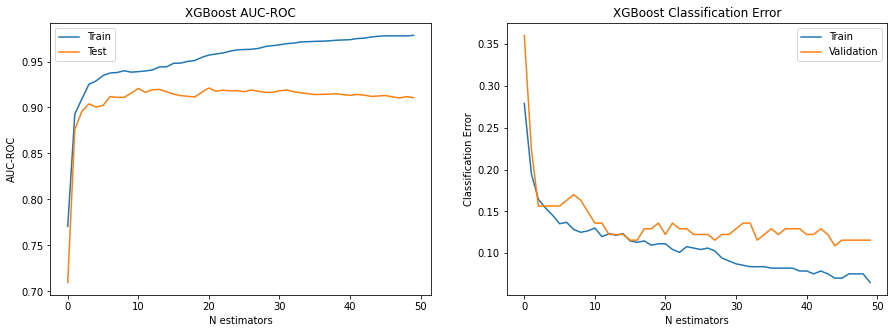


 Confusion Matrix:
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

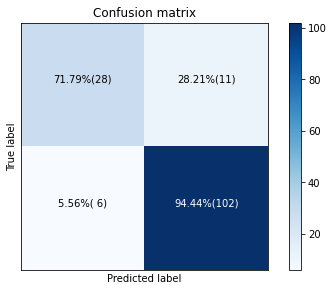

In [ ]:
seed = 100

# split the clean_X into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)


import time
from xgboost import XGBClassifier
# create an XGBoost classifier
# model = XGBClassifier(n_estimators=50, random_state=seed, learning_rate=1, max_depth=10, objective='binary:logistic', booster='gbtree', feval='rmsle',
#                       subsample= 0.8, reg_lambda = 0.1, reg_alpha = 0.1, min_child_weight = 0.1, scale_pos_weight = 1/2.08, colsample_bytree = 0.6, tree_method = 'exact')

# ARCHIVE: 88% accuracy was reached with: 
model = XGBClassifier(n_estimators=50, random_state=seed, learning_rate=0.1, max_depth=5, objective='binary:logistic', booster='gbtree', feval='rmsle',
                      reg_lambda = 1.5, reg_alpha = 0.05, min_child_weight = 0.1, scale_pos_weight = 0.8, colsample_bytree = 0.6)


# define the eval set and metric
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]

# fit the model
%time
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)



from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# model assessment
pred_train = model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))

pred_test = model.predict(X_test)
print('Test Accuracy: ', accuracy_score(y_test, pred_test))

print('Classification Report:')
print(classification_report(y_test,pred_test,zero_division=0))



# CHECK ACCURACY MANUALLY TO BE SURE AND LOOK AT SOME RESULTS:
# print('calculate accuracy manually:', '\n')
# print('accuracy vec: ', accuracy_vec, 'true labels: ', y_test)
# train_accuracy_vec = pred_train == y_train
# test_accuracy_vec = pred_test == y_test
# print('train test accuracy is:', np.round(train_accuracy_vec.sum()/len(train_accuracy_vec), 3))
# print('manual test accuracy is:', np.round(test_accuracy_vec.sum()/len(test_accuracy_vec), 3))



# retrieve performance metrics and plot AUC-ROC and classification error
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
# plot auc
ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[0].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[0].legend()
ax[0].set_title('XGBoost AUC-ROC')
ax[0].set_ylabel('AUC-ROC')
ax[0].set_xlabel('N estimators')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Validation')
ax[1].legend()
ax[1].set_title('XGBoost Classification Error')
ax[1].set_ylabel('Classification Error')
ax[1].set_xlabel('N estimators')
plt.show()
plt.tight_layout()

# show confusion matrix
from sklearn.metrics import confusion_matrix
print('\n Confusion Matrix:')
# print(confusion_matrix(y_test,pred_test))
plot_confusion_matrix(confusion_matrix(y_test,pred_test), numbers_type='numbers_and_percentage')



# plot specific trees
plt.rcParams['figure.figsize'] = [15, 10]
# xgb.plot_tree(model,num_trees=0, rankdir='LR')
# xgb.plot_tree(model,num_trees=1, rankdir='LR')
# xgb.plot_tree(model,num_trees=31, rankdir='LR')


# SAVE MODEL TO FILE
import pickle
file_name = "XGBmodel_051221.pkl"
# save
pickle.dump(model, open(file_name, "wb"))
!cp "XGBmodel_051221.pkl" /content/drive/MyDrive/Project_A/Project_A_files

In [ ]:
# # FINDING THE BEST SCALE_POS_WEIGHT (due to the imbalanced dataset)

# from sklearn.model_selection import RepeatedStratifiedKFold
# # define grid
# weights = [0.8, 1.09]
# param_grid = dict(scale_pos_weight=weights)

# # define evaluation procedure
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define grid search
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# # execute the grid search
# grid_result = grid.fit(X, y)
# # report the best configuration
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# # report all configurations
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

[0.02554193 0.01985412 0.02956128 0.00819669 0.         0.01908246
 0.0205054  0.02320582 0.03453508 0.01223013 0.02133787 0.02077959
 0.03144952 0.0282018  0.         0.00935954 0.04445372 0.02774355
 0.02818491 0.0169268  0.02613023 0.01886095 0.02903987 0.01737951
 0.         0.00871686 0.0298785  0.04438981 0.04124151 0.02583332
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.20183793 0.10725552
 0.02828584]


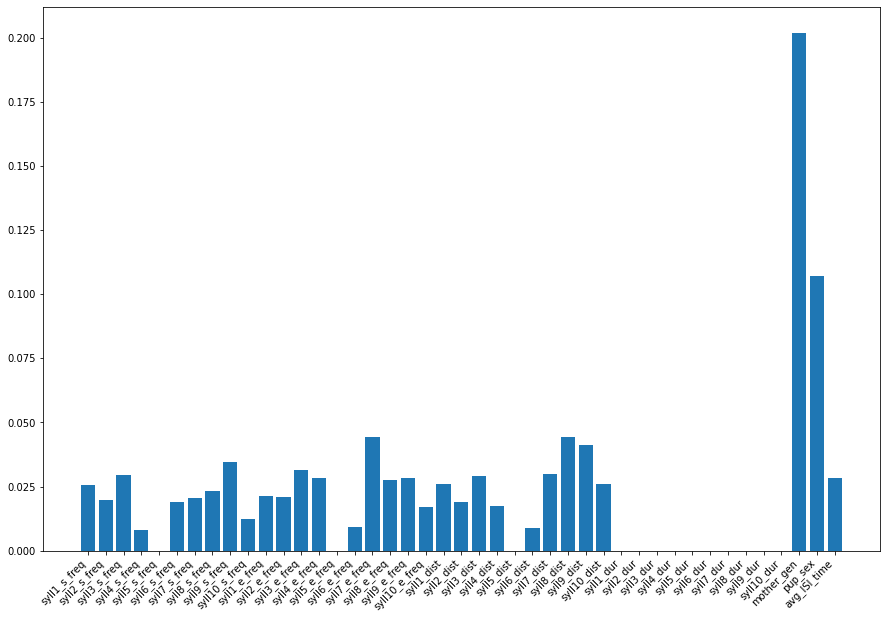

In [ ]:
# PLOT FEATURE IMPORTANCE - MANUALLY
print(model.feature_importances_)

import matplotlib.pyplot as plt
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xticks(range(len(model.feature_importances_)), col_names, rotation=45, ha="right")
plt.show()

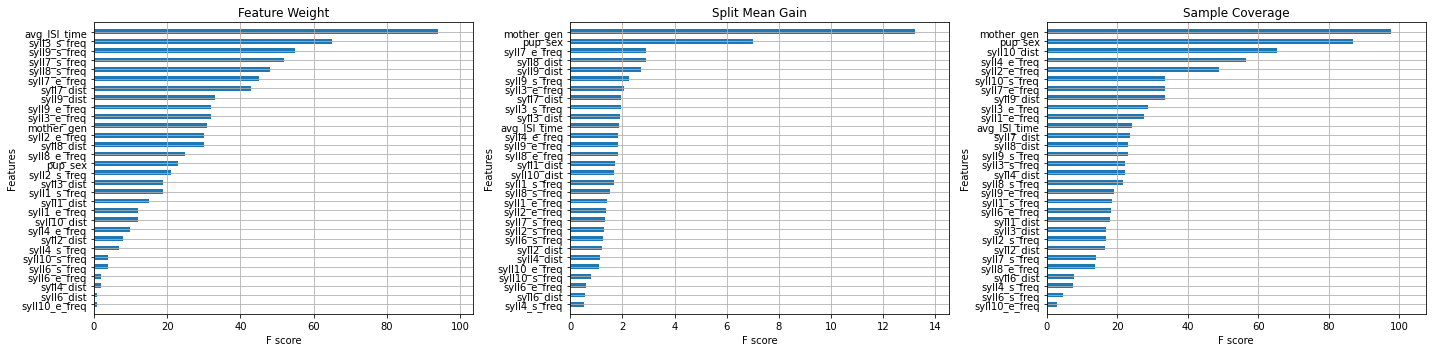

In [ ]:
# PLOT FEATURE IMPORTANCE:

fig, ax = plt.subplots(1, 3, figsize=(20,5))
# plot importances with feature weight

xgb.plot_importance(
    booster=model, 
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
    ax=ax[0]
)
# plot importances with split mean gain
xgb.plot_importance(
    booster=model,
    importance_type='gain',
    title='Split Mean Gain',
    show_values=False,
    height=0.5,
    ax=ax[1]
)
# plot importances with sample coverage
xgb.plot_importance(
    model,
    importance_type='cover',
    title='Sample Coverage',
    show_values=False,
    height=0.5,
    ax=ax[2]
)
plt.tight_layout()
plt.show()

***by using GridSearch (archived below):***

Best model: {'subsample': 0.8, 'reg_lambda': 1, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}

ARCHIVE - USING GRIDSEARCH TO FIND BEST HYPER-PARAMETERS
---

In [ ]:
#---------------------------------------------------------

# create a default XGBoost classifier
from sklearn.metrics import make_scorer
seed = 1000
model = XGBClassifier(
    random_state=seed, 
    eval_metric=["error", "auc"]
)
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [1, 0.5,0.1, 0.01, 0.001],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4, 5, 10],
    "n_estimators": [25, 50, 100, 200, 300, 400, 500],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
    "reg_alpha": [0.005, 0.01, 0.05, 0.1, 0.5],
    "colsample_bytree": [0.4, 0.6, 0.8, 1]
}

scoring = {
    'AUC': 'roc_auc',
     'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds)#, random_state=seed)
# create the grid search object
n_iter=50
grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
)
# fit grid search
%time best_model = grid.fit(X_train,y_train)
from sklearn.metrics import confusion_matrix

print(f'Best score: {best_model.best_score_}')
print(f'Best model: {best_model.best_params_}')

pred_test = best_model.predict(X_test)
pred_train = best_model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

# store the winning model in a new variable
xgc = best_model.best_estimator_
# saving the feature names to the model
xgc.get_booster().feature_names = X.columns.to_list()
# PLOT FEATURE IMPORTANCE:
# # Create the feature importances plot
# fig, ax = plt.subplots(1, 3, figsize=(15,5))
# # plot importances with feature weight
# xgb.plot_importance(
#     booster=xgc, 
#     importance_type='weight',
#     title='Feature Weight',
#     show_values=False,
#     height=0.5,
#     ax=ax[0],
# )
# # plot importances with split mean gain
# xgb.plot_importance(
#     booster=xgc,
#     importance_type='gain',
#     title='Split Mean Gain',
#     show_values=False,
#     height=0.5,
#     ax=ax[1]
# )
# # plot importances with sample coverage
# xgb.plot_importance(
#     xgc,
#     importance_type='cover',
#     title='Sample Coverage',
#     show_values=False,
#     height=0.5,
#     ax=ax[2]
# )
# plt.tight_layout()
# plt.show()


# TAKEN FROM EXAMPLE WITHOUT GRID SEARCH:
# retrieve performance metrics
results = xgc.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
# plot auc
ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[0].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[0].legend()
ax[0].set_title('XGBoost AUC-ROC')
ax[0].set_ylabel('AUC-ROC')
ax[0].set_xlabel('N estimators')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_title('XGBoost Classification Error')
ax[1].set_ylabel('Classification Error')
ax[1].set_xlabel('N estimators')
plt.show()
plt.tight_layout()


# plot a decision tree from the booster
xgb.plot_tree(booster=xgc, num_trees=0, ax=ax, rankdir='LR')
plt.tight_layout()
plt.show()

CPU times: user 2.77 s, sys: 181 ms, total: 2.95 s
Wall time: 53.4 s
Best score: 0.8054386425540271
Best model: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.005, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1}
Train Accuracy:  0.9366438356164384
Test Accuraccy:  0.8299319727891157

Confusion Matrix:
[[23 16]
 [ 9 99]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.59      0.65        39
         1.0       0.86      0.92      0.89       108

    accuracy                           0.83       147
   macro avg       0.79      0.75      0.77       147
weighted avg       0.82      0.83      0.82       147



AttributeError: ignored

ARCHIVE - TUNE LEARNING RATE (from source 7)
---

In [ ]:
# # XGBoost on Otto dataset, Tune learning_rate and n_estimators
# from pandas import read_csv
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import LabelEncoder
# import matplotlib
# matplotlib.use('Agg')
# from matplotlib import pyplot
# import numpy
# # load data
# # data = read_csv('train.csv')
# # dataset = data.values
# # # split data into X and y
# # X = dataset[:,0:94]
# # y = dataset[:,94]
# # encode string class values as integers
# label_encoded_y = LabelEncoder().fit_transform(y)
# # grid search
# model = XGBClassifier()
# n_estimators = [100, 200, 300, 400, 500]
# learning_rate = [0.0001, 0.001, 0.01, 0.1]
# param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
# grid_result = grid_search.fit(X, label_encoded_y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
# 	print("%f (%f) with: %r" % (mean, stdev, param))
# # plot results
# scores = numpy.array(means).reshape(len(learning_rate), len(n_estimators))
# for i, value in enumerate(learning_rate):
#     pyplot.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
# pyplot.legend()
# pyplot.xlabel('n_estimators')
# pyplot.ylabel('Log Loss')
# pyplot.savefig('n_estimators_vs_learning_rate.png')